In [30]:
!pip install -U pip setuptools wheel
!pip install -U "matplotlib>=3.8" "seaborn>=0.13" pandas numpy

In [31]:
import matplotlib
print(matplotlib.__version__)  # should be >= 3.4

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
# import seaborn as sns


3.9.4


In [48]:


# ---------- 1. Load JSON Lines file ----------
file_path = "../data/customer_churn.json"
df = pd.read_json(file_path, lines=True)

# ---------- 2. Convert timestamps ----------
df['datetime'] = pd.to_datetime(df['ts'], unit='ms', errors='coerce')
df['registration_datetime'] = pd.to_datetime(df['registration'], unit='ms', errors='coerce')

# ---------- 3. Add derived columns ----------
df['date'] = df['datetime'].dt.date
df['hour'] = df['datetime'].dt.hour

# Days since registration
df['days_since_registration'] = (df['datetime'] - df['registration_datetime']).dt.days

# ---------- 4. Session duration (in minutes) ----------
session_duration = df.groupby('sessionId')['datetime'].agg(lambda x: (x.max() - x.min()).total_seconds() / 60)
df = df.merge(session_duration.rename('session_duration_min'), on='sessionId', how='left')

# ---------- 5. Extract browser & OS ----------
# Browser
df['agent_simple'] = df['userAgent'].str.extract(r'(Firefox|Chrome|Safari|Edge|MSIE|Opera)')
# OS
df['os_simple'] = df['userAgent'].str.extract(r'(Windows|Macintosh|Linux|iPhone|Android)')

# ---------- 6. Handle missing values ----------
# Keep NaNs for now; we’ll decide case-by-case in plotting
df['userId'] = df['userId'].replace('', np.nan)

# ---------- 7. Quick sanity check ----------
print(df.shape)
df.head()

(543705, 26)


,ts,userId,sessionId,page,auth,method,status,level,itemInSession,location,...,song,length,datetime,registration_datetime,date,hour,days_since_registration,session_duration_min,agent_simple,os_simple
0,1538352011000,293,292,NextSong,Logged In,PUT,200,free,20,"Corpus Christi, TX",...,Grand Designs,597.55057,2018-10-01 00:00:11,2018-07-20 05:11:47,2018-10-01,0,72.0,44637.966667,Chrome,Macintosh
1,1538352025000,98,97,NextSong,Logged In,PUT,200,free,74,"Houston-The Woodlands-Sugar Land, TX",...,Bulls,380.21179,2018-10-01 00:00:25,2018-09-27 17:33:58,2018-10-01,0,3.0,49953.833333,Chrome,Macintosh
2,1538352118000,179,178,NextSong,Logged In,PUT,200,paid,184,"Orlando-Kissimmee-Sanford, FL",...,Because I Got High,202.37016,2018-10-01 00:01:58,2018-09-03 05:44:15,2018-10-01,0,27.0,18346.950000,Chrome,Macintosh
3,1538352119000,179,178,Logout,Logged In,PUT,307,paid,185,"Orlando-Kissimmee-Sanford, FL",...,NaN,NaN,2018-10-01 00:01:59,2018-09-03 05:44:15,2018-10-01,0,27.0,18346.950000,Chrome,Macintosh
4,1538352124000,246,245,NextSong,Logged In,PUT,200,paid,22,"Mobile, AL",...,Smile (Radio Edit),194.53342,2018-10-01 00:02:04,2018-09-02 23:30:18,2018-10-01,0,28.0,39693.983333,Firefox,Windows


# 1) Verify churn meaning (check-only, don’t mutate df)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# work on a sorted copy (we won't mutate df until logic is verified)
df_chk = df.sort_values(['userId', 'datetime']).copy()

# churn pages per your definition
churn_pages = {"Submit Downgrade"}

# neighbors
prev_level = df_chk.groupby('userId')['level'].shift()
next_level = df_chk.groupby('userId')['level'].shift(-1)

# check-only churn flag (event-level)
is_churn_event = (
    df_chk['page'].isin(churn_pages) &
    (prev_level == 'paid') &
    (next_level == 'free')
)

print("Detected churn events (check-only):", int(is_churn_event.sum()))

# assertions to ensure logic is exactly as intended
assert (prev_level[is_churn_event] == 'paid').all(), "❌ Found churn events where prev_level != 'paid'"
assert (next_level[is_churn_event] == 'free').all(), "❌ Found churn events where next_level != 'free'"
print("✅ Churn meaning verified.")

Detected churn events (check-only): 117
✅ Churn meaning verified.


In [40]:
# Inspect churn events & context (N events, ±M rows)

from IPython.display import display

# quick look at churn rows (page etc.)
cols_view = ['datetime','userId','sessionId','page','level','auth','status','location','gender']
churn_events_df = df_chk.loc[is_churn_event, cols_view].copy()

def show_churn_context(df_sorted, churn_mask, N=5, M=3):
    churn_idxs = df_sorted.index[churn_mask].tolist()[:N]
    # per-user index cache
    user_positions = {uid: list(grp.index) for uid, grp in df_sorted.groupby('userId')}
    for i, idx in enumerate(churn_idxs, start=1):
        uid = df_sorted.loc[idx, 'userId']
        idx_list = user_positions[uid]
        pos = idx_list.index(idx)
        start = max(pos - M, 0)
        end = min(pos + M + 1, len(idx_list))
        window = df_sorted.loc[idx_list[start:end], ['datetime','page','level','sessionId','status','auth']].copy()
        window['__is_churn_row__'] = window.index == idx
        print(f"\n=== Churn #{i}: userId={uid}, churn_at={df_sorted.loc[idx,'datetime']} ===")
        display(window)

show_churn_context(df_chk, is_churn_event, N=3, M=5)


=== Churn #1: userId=100002, churn_at=2018-11-02 08:10:09 ===


,datetime,page,level,sessionId,status,auth,__is_churn_row__
422859,2018-11-02 08:02:55,NextSong,paid,293,200,Logged In,False
422860,2018-11-02 08:06:42,NextSong,paid,293,200,Logged In,False
422861,2018-11-02 08:09:34,NextSong,paid,293,200,Logged In,False
422862,2018-11-02 08:09:45,Home,paid,293,200,Logged In,False
422863,2018-11-02 08:10:08,Downgrade,paid,293,200,Logged In,False
422864,2018-11-02 08:10:09,Submit Downgrade,paid,293,307,Logged In,True
422865,2018-11-02 08:10:18,Home,free,293,200,Logged In,False
422866,2018-11-02 08:14:09,NextSong,free,293,200,Logged In,False
422867,2018-11-02 08:14:10,Logout,free,293,307,Logged In,False
422870,2018-11-02 08:14:46,Home,free,293,200,Logged In,False



=== Churn #2: userId=100006, churn_at=2018-11-08 00:16:25 ===


,datetime,page,level,sessionId,status,auth,__is_churn_row__
425190,2018-11-08 00:04:56,NextSong,paid,304,200,Logged In,False
425191,2018-11-08 00:08:17,NextSong,paid,304,200,Logged In,False
425192,2018-11-08 00:11:30,NextSong,paid,304,200,Logged In,False
425193,2018-11-08 00:16:22,NextSong,paid,304,200,Logged In,False
425194,2018-11-08 00:16:24,Downgrade,paid,304,200,Logged In,False
425195,2018-11-08 00:16:25,Submit Downgrade,paid,304,307,Logged In,True
425196,2018-11-08 00:16:29,Home,free,304,200,Logged In,False
425197,2018-11-08 00:22:00,NextSong,free,304,200,Logged In,False
425198,2018-11-08 00:24:58,NextSong,free,304,200,Logged In,False
425199,2018-11-08 00:25:03,Roll Advert,free,304,200,Logged In,False



=== Churn #3: userId=100007, churn_at=2018-11-29 00:30:34 ===


,datetime,page,level,sessionId,status,auth,__is_churn_row__
431205,2018-11-29 00:17:04,NextSong,paid,391,200,Logged In,False
431206,2018-11-29 00:21:19,NextSong,paid,391,200,Logged In,False
431207,2018-11-29 00:25:15,NextSong,paid,391,200,Logged In,False
431208,2018-11-29 00:30:00,NextSong,paid,391,200,Logged In,False
431209,2018-11-29 00:30:33,Downgrade,paid,391,200,Logged In,False
431210,2018-11-29 00:30:34,Submit Downgrade,paid,391,307,Logged In,True
431211,2018-11-29 00:30:37,Home,free,391,200,Logged In,False
431212,2018-11-29 00:33:42,NextSong,free,391,200,Logged In,False
431213,2018-11-29 00:37:31,NextSong,free,391,200,Logged In,False
431214,2018-11-29 00:41:33,NextSong,free,391,200,Logged In,False


# 2) Mark churned users (now we mutate safely)

In [41]:
# commit churn event to df (event-level)
df = df.sort_values(['userId','datetime']).copy()
df['prev_level'] = df.groupby('userId')['level'].shift()
df['next_level'] = df.groupby('userId')['level'].shift(-1)
df['is_churn'] = (
    df['page'].isin(churn_pages) &
    (df['prev_level'] == 'paid') &
    (df['next_level'] == 'free')
)

# first churn timestamp per user
user_churn_date = df.loc[df['is_churn']].groupby('userId')['datetime'].min()
df['is_churned_user'] = df['userId'].isin(user_churn_date.index)

print(f"Churned users: {len(user_churn_date)} / {df['userId'].nunique()}")

Churned users: 97 / 449


# 3) Compute time to churn (days)

Median time to churn: 22.0 days
Mean time to churn: 23.5 days
Min: 0 days, Max: 58 days


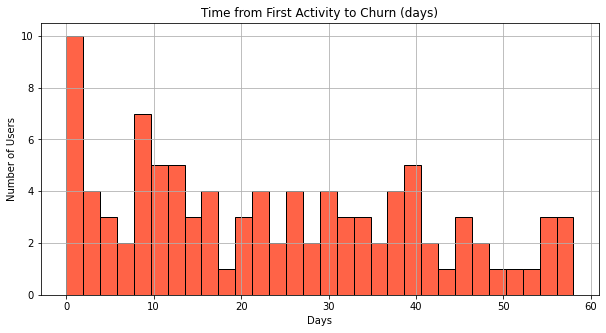

In [42]:
# First activity date for each churned user
first_activity = df.groupby('userId')['datetime'].min()

# Time from first activity to first churn
time_to_churn_days = (user_churn_date - first_activity[user_churn_date.index]).dt.days

print(f"Median time to churn: {time_to_churn_days.median():.1f} days")
print(f"Mean time to churn: {time_to_churn_days.mean():.1f} days")
print(f"Min: {time_to_churn_days.min()} days, Max: {time_to_churn_days.max()} days")

plt.figure(figsize=(10,5))
time_to_churn_days.dropna().plot(kind='hist', bins=30, color='tomato', edgecolor='black')
plt.title("Time from First Activity to Churn (days)")
plt.xlabel("Days")
plt.ylabel("Number of Users")
plt.grid(True)
plt.show()

# 4) Check who churned then subscribed again

In [43]:
subscribe_pages = {"Submit Upgrade"}

records = []

for user, churn_time in user_churn_date.items():
    # First subscribe before churn
    first_subscribe = df[
        (df['userId'] == user) &
        (df['page'].isin(subscribe_pages)) &
        (df['datetime'] < churn_time)
    ]['datetime'].min()

    # First re-subscribe after churn
    first_resubscribe = df[
        (df['userId'] == user) &
        (df['page'].isin(subscribe_pages)) &
        (df['datetime'] > churn_time)
    ]['datetime'].min()

    if pd.notna(first_resubscribe):
        days_between = (first_resubscribe - churn_time).days
        records.append({
            'userId': user,
            'first_subscribe': first_subscribe,
            'churn_date': churn_time,
            'first_resubscribe': first_resubscribe,
            'days_between_churn_and_resubscribe': days_between
        })

resubscribe_df = pd.DataFrame(records)

# With unique users
unique_users_resub = resubscribe_df['userId'].nunique()
# Without unique (counting each resubscribe event)
total_resub_events = len(resubscribe_df)

print(f"Unique users who churned and re-subscribed: {unique_users_resub}")
print(f"Total churn → re-subscribe events: {total_resub_events}")

resubscribe_df.head()

Unique users who churned and re-subscribed: 61
Total churn → re-subscribe events: 61


,userId,first_subscribe,churn_date,first_resubscribe,days_between_churn_and_resubscribe
0,100009,2018-10-01 10:17:58,2018-10-29 03:12:45,2018-11-04 22:14:53,6
1,100011,2018-10-04 08:33:19,2018-10-30 10:01:16,2018-11-08 16:02:28,9
2,100021,2018-10-11 18:27:50,2018-11-02 11:45:10,2018-11-02 16:10:21,0
3,100022,2018-10-03 04:02:17,2018-10-10 03:23:16,2018-10-15 05:07:04,5
4,100024,2018-10-04 15:52:53,2018-10-11 21:04:57,2018-10-25 01:06:45,13


# 5) Visualisations


## 5a) Gender split: churned vs not churned (user-level)

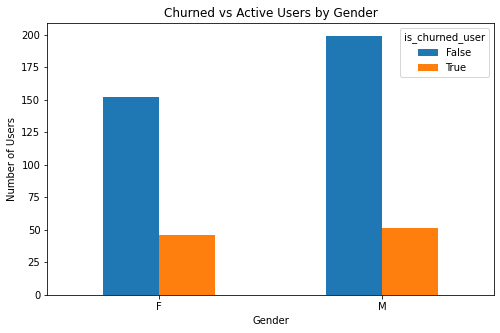

In [44]:
user_level = (
    df.drop_duplicates('userId')[['userId','gender','is_churned_user']]
    .copy()
)

counts = user_level.groupby(['gender','is_churned_user'])['userId'].count().unstack(fill_value=0)

ax = counts.plot(kind='bar', figsize=(8,5))
ax.set_title("Churned vs Active Users by Gender")
ax.set_ylabel("Number of Users")
ax.set_xlabel("Gender")
plt.xticks(rotation=0)
plt.show()

## 5b) Time-to-churn histogram (days)

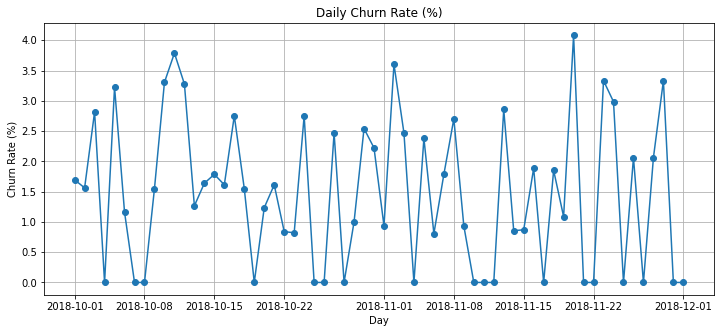

In [45]:
# Count churned users per day
churn_by_day = user_churn_date.groupby(user_churn_date.dt.to_period('D')).count()

# Active users per day
active_users_by_day = df.groupby(df['datetime'].dt.to_period('D'))['userId'].nunique()

# Churn rate
daily_churn_rate = (churn_by_day / active_users_by_day).reindex(active_users_by_day.index).fillna(0) * 100

plt.figure(figsize=(12,5))
plt.plot(daily_churn_rate.index.to_timestamp(), daily_churn_rate.values, marker='o')
plt.title("Daily Churn Rate (%)")
plt.ylabel("Churn Rate (%)")
plt.xlabel("Day")
plt.grid(True)
plt.show()

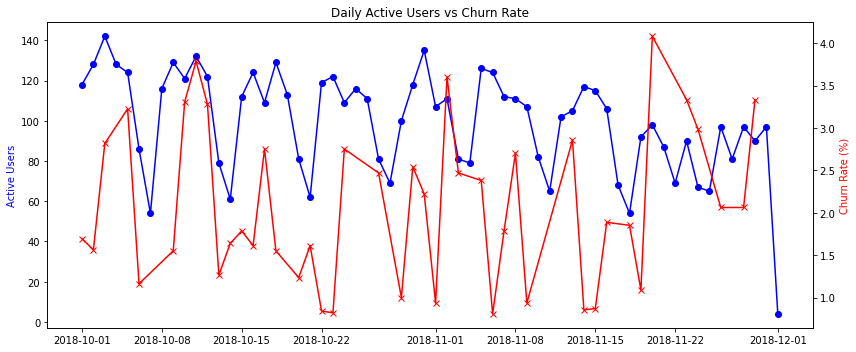

In [46]:
fig, ax1 = plt.subplots(figsize=(12,5))

ax1.plot(active_users_by_day.index.to_timestamp(), active_users_by_day.values, 
         color='blue', marker='o', label='Active Users')
ax1.set_ylabel("Active Users", color='blue')

ax2 = ax1.twinx()
ax2.plot(churn_by_day.index.to_timestamp(), 
         (churn_by_day.values / active_users_by_day.reindex(churn_by_day.index).values)*100, 
         color='red', marker='x', label='Churn Rate (%)')
ax2.set_ylabel("Churn Rate (%)", color='red')

plt.title("Daily Active Users vs Churn Rate")
fig.tight_layout()
plt.show()

## Churn rate by day of month (1–31)

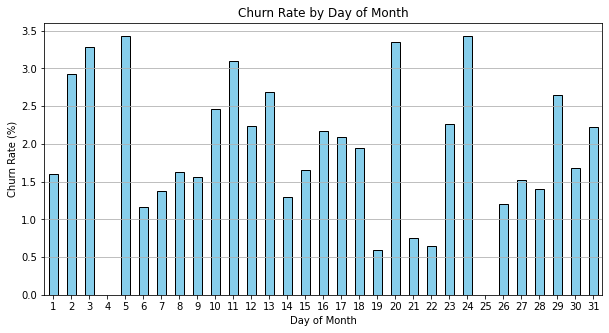

In [37]:
# Extract day of month from churn date
day_of_month = user_churn_date.dt.day

# Count churn events per day of month
churn_counts_dom = day_of_month.value_counts().sort_index()

# Active users aggregated over all months by day of month
active_users_dom = df.groupby(df['datetime'].dt.day)['userId'].nunique()

# Churn rate for each day of month
dom_rate = (churn_counts_dom / active_users_dom).fillna(0) * 100

plt.figure(figsize=(10,5))
dom_rate.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Churn Rate by Day of Month")
plt.ylabel("Churn Rate (%)")
plt.xlabel("Day of Month")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

## Churn rate by day of week (Mon–Sun)

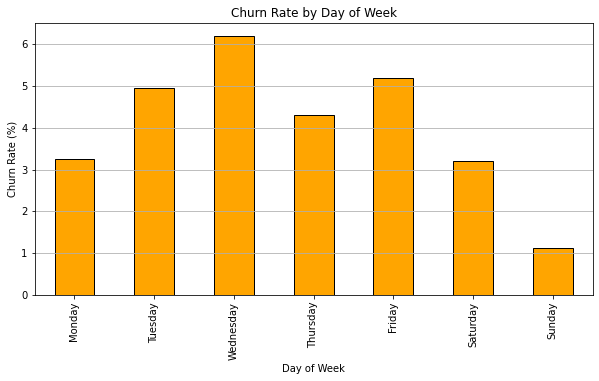

In [38]:
# Extract weekday name from churn date
day_of_week = user_churn_date.dt.day_name()

# Count churn events per weekday
churn_counts_dow = day_of_week.value_counts().reindex(
    ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
)

# Active users aggregated over all weeks by weekday
active_users_dow = df.groupby(df['datetime'].dt.day_name())['userId'].nunique().reindex(
    ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
)

# Churn rate for each day of week
dow_rate = (churn_counts_dow / active_users_dow).fillna(0) * 100

plt.figure(figsize=(10,5))
dow_rate.plot(kind='bar', color='orange', edgecolor='black')
plt.title("Churn Rate by Day of Week")
plt.ylabel("Churn Rate (%)")
plt.xlabel("Day of Week")
plt.grid(axis='y')
plt.show()

In [26]:
import numpy as np
import pandas as pd

# 0) Normalize userId (very important)
df = df.copy()
df['userId'] = df['userId'].replace('', np.nan)

# 1) Pick a single base index of users (non-null)
base_index = pd.Index(sorted(df['userId'].dropna().unique()))

def align(s):
    """Ensure every Series uses the same userId index."""
    return s.reindex(base_index)

# 2) Recompute any intermediates that depended on userId (safe)
user_gender_code        = align(df.drop_duplicates('userId').set_index('userId')['gender'].map({'F':0,'M':1}).fillna(-1))
user_reg                = align(df.drop_duplicates('userId').set_index('userId')['registration_datetime'])
user_last               = df.groupby('userId')['datetime'].max()
account_age_days        = align((user_last - user_reg).dt.days)

total_events            = align(df.groupby('userId').size())
total_sessions          = align(df.groupby('userId')['sessionId'].nunique())
unique_pages            = align(df.groupby('userId')['page'].nunique())
unique_days_active      = align(df.groupby('userId')['datetime'].apply(lambda x: x.dt.date.nunique()))
events_per_session      = (total_events / total_sessions.replace(0, np.nan)).reindex(base_index)

total_hearing_time      = align(df.groupby('userId')['length'].sum(min_count=1))
mean_hearing_time       = align(df.groupby('userId')['length'].mean())
hearing_time_variance   = align(df.groupby('userId')['length'].var())

def change_rate(series):
    s = series.dropna()
    if len(s) < 3: return np.nan
    k = len(s)//3
    if k == 0: return np.nan
    start_avg = s.iloc[:k].mean()
    end_avg   = s.iloc[-k:].mean()
    return (end_avg - start_avg)/start_avg if start_avg else np.nan

hearing_time_change_rate = align(df.groupby('userId')['length'].apply(change_rate))

# Browsers/OS (if not already extracted)
df['browser'] = df['userAgent'].str.extract(r'(Firefox|Chrome|Safari|Edge|MSIE|Opera)')
df['os']      = df['userAgent'].str.extract(r'(Windows|Macintosh|Linux|iPhone|Android)')

unique_user_agents      = align(df.groupby('userId')['userAgent'].nunique())
unique_browsers         = align(df.groupby('userId')['browser'].nunique())
unique_os               = align(df.groupby('userId')['os'].nunique())

avg_hour_active         = align(df.groupby('userId')['datetime'].apply(lambda x: x.dt.hour.mean()))
# Guard mode() on empty
most_common_day         = align(df.groupby('userId')['datetime'].apply(lambda x: x.dt.dayofweek.mode().iloc[0] if len(x)>0 and not x.dt.dayofweek.mode().empty else np.nan))
avg_day_of_month        = align(df.groupby('userId')['datetime'].apply(lambda x: x.dt.day.mean()))

dataset_end             = df['datetime'].max()
days_since_last_activity= align((dataset_end - user_last).dt.days)

def activity_change(series):
    if len(series) < 4: return np.nan
    mid = len(series)//2
    first_rate  = series.iloc[:mid].dt.date.value_counts().mean()
    second_rate = series.iloc[mid:].dt.date.value_counts().mean()
    return (second_rate - first_rate)/first_rate if first_rate else np.nan

activity_change_rate    = align(df.groupby('userId')['datetime'].apply(activity_change))

paid_event_share        = align(df['level'].eq('paid').groupby(df['userId']).mean())

# time_to_churn_days (built earlier as time_to_churn_days) aligned to users
time_to_churn_days_user = align(time_to_churn_days)

# churned flag aligned
is_churned_user_flag    = pd.Series(base_index.isin(getattr(user_churn_date, 'index', [])), index=base_index).astype(int)

# 3) Combine by index alignment
user_features = pd.DataFrame({
    'gender_code':               user_gender_code,
    'account_age_days':          account_age_days,
    'total_events':              total_events,
    'total_sessions':            total_sessions,
    'unique_pages':              unique_pages,
    'unique_days_active':        unique_days_active,
    'events_per_session':        events_per_session,
    'total_hearing_time':        total_hearing_time,
    'mean_hearing_time':         mean_hearing_time,
    'hearing_time_variance':     hearing_time_variance,
    'hearing_time_change_rate':  hearing_time_change_rate,
    'unique_user_agents':        unique_user_agents,
    'unique_browsers':           unique_browsers,
    'unique_os':                 unique_os,
    'avg_hour_active':           avg_hour_active,
    'most_common_day':           most_common_day,
    'avg_day_of_month':          avg_day_of_month,
    'days_since_last_activity':  days_since_last_activity,
    'activity_change_rate':      activity_change_rate,
    'paid_event_share':          paid_event_share,
    'time_to_churn_days':        time_to_churn_days_user,
    'is_churned_user':           is_churned_user_flag
}, index=base_index)

# Optional: quick sanity checks
print(user_features.shape)
assert user_features.shape[0] == len(base_index), "Row count mismatch after assembly"
assert not user_features.index.hasnans, "Found NaN in user index"

user_features.head()

(448, 22)


,gender_code,account_age_days,total_events,total_sessions,unique_pages,unique_days_active,events_per_session,total_hearing_time,mean_hearing_time,hearing_time_variance,...,unique_browsers,unique_os,avg_hour_active,most_common_day,avg_day_of_month,days_since_last_activity,activity_change_rate,paid_event_share,time_to_churn_days,is_churned_user
10,1.0,10,423,1,13,2,423.000000,90524.44076,251.456780,7358.586789,...,1,1,10.867612,0,8.144208,52,-0.497630,1.000000,NaN,0
100,1.0,65,3999,39,16,36,102.538462,829748.33112,245.342499,7549.423494,...,1,1,11.363591,3,15.840210,0,0.056084,0.984996,NaN,0
100001,0.0,44,134,3,14,2,44.666667,23795.33930,247.868118,7521.590342,...,1,1,9.850746,1,1.514925,59,1.000000,0.000000,NaN,0
100002,0.0,129,177,4,12,4,44.250000,36769.06108,268.387307,12647.314104,...,1,1,9.005650,4,11.299435,28,3.045455,0.757062,23.0,1
100003,0.0,50,827,9,18,11,91.888889,162292.65050,245.525946,6930.238252,...,1,1,14.102781,6,17.165659,22,0.403390,0.621524,NaN,0


In [ ]:
series_dict = {
    'gender_code': user_gender_code,
    'account_age_days': account_age_days,
    'total_events': total_events,
    'total_sessions': total_sessions,
    'unique_pages': unique_pages,
    'unique_days_active': unique_days_active,
    'events_per_session': events_per_session,
    'total_hearing_time': total_hearing_time,
    'mean_hearing_time': mean_hearing_time,
    'hearing_time_variance': hearing_time_variance,
    'hearing_time_change_rate': hearing_time_change_rate,
    'unique_user_agents': unique_user_agents,
    'unique_browsers': unique_browsers,
    'unique_os': unique_os,
    'avg_hour_active': avg_hour_active,
    'most_common_day': most_common_day,
    'avg_day_of_month': avg_day_of_month,
    'days_since_last_activity': days_since_last_activity,
    'activity_change_rate': activity_change_rate,
    ' ': paid_event_share,
    'time_to_churn_days': time_to_churn_days_user,
}

for name, s in series_dict.items():
    missing = base_index.difference(s.index)
    if len(missing) or len(s) != len(base_index):
        print(f"{name}: len={len(s)}; missing users={list(missing)[:5]}{'...' if len(missing)>5 else ''}")

is_churned_user             1.000000
unique_pages                0.456608
total_sessions              0.390336
unique_days_active          0.373689
total_events                0.341776
total_hearing_time          0.334332
paid_event_share            0.181119
account_age_days            0.157314
events_per_session          0.095161
unique_browsers             0.052361
hearing_time_variance       0.047040
avg_day_of_month            0.037909
mean_hearing_time           0.033334
hearing_time_change_rate    0.029760
most_common_day             0.013238
unique_os                  -0.001983
gender_code                -0.034151
activity_change_rate       -0.042223
avg_hour_active            -0.051752
days_since_last_activity   -0.188949
unique_user_agents               NaN
time_to_churn_days               NaN
Name: is_churned_user, dtype: float64

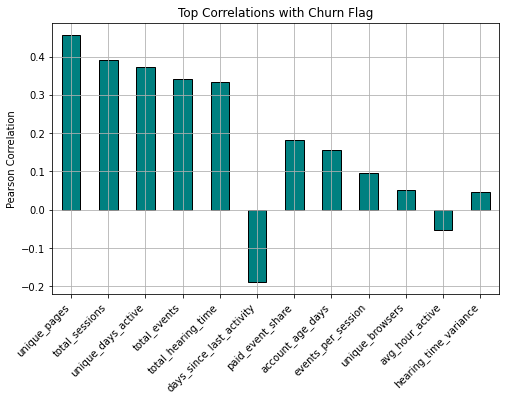

In [28]:
import matplotlib.pyplot as plt

# Compute Pearson correlations
corr_series = user_features.corr(numeric_only=True)['is_churned_user'].sort_values(ascending=False)

# Show all correlations
display(corr_series)

# Top absolute correlations (excluding the target itself)
top_k = 12
corr_no_target = corr_series.drop('is_churned_user')
top_abs = corr_no_target.reindex(
    corr_no_target.abs().sort_values(ascending=False).head(top_k).index
)

# Plot
plt.figure(figsize=(8,5))
top_abs.plot(kind='bar', color='teal', edgecolor='black')
plt.title("Top Correlations with Churn Flag")
plt.ylabel("Pearson Correlation")
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.show()

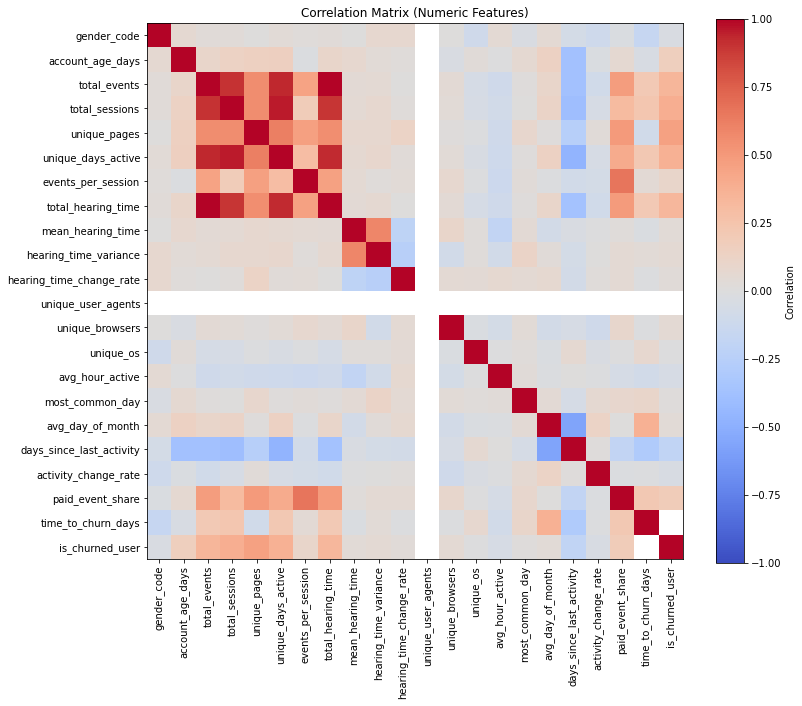

In [29]:
import numpy as np

corr_matrix = user_features.corr(numeric_only=True)

plt.figure(figsize=(12,10))
plt.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Correlation')
plt.xticks(ticks=np.arange(len(corr_matrix.columns)), labels=corr_matrix.columns, rotation=90)
plt.yticks(ticks=np.arange(len(corr_matrix.columns)), labels=corr_matrix.columns)
plt.title("Correlation Matrix (Numeric Features)")
plt.show()